## Introduction

This notebook presents the Python component of the project “Exploratory Analysis of COVID-19 (2020–2025)”, conducted using the full global dataset from *Our World in Data*.  
It follows the SQL phase of the study — which covered data validation, cleaning, and first-level analytical queries — and transforms the exported outputs into structured visual insights.

The central question guiding this exploratory analysis is the following:  
**How did transmission, mortality, vaccination, demographic structure, and policy responses interact to shape the global evolution of COVID-19 between 2020 and 2025?**

To answer this, the notebook analyzes major dimensions of the pandemic using Using **Pandas** and **NumPy** for data manipulation, and **Matplotlib** and **Seaborn** for visualization. The study covers global case and death dynamics, vaccination progress, continental disparities, and the influence of broader structural or policy-related factors such as life expectancy or stringency level.

The objective is to provide a coherent exploratory narrative that highlights key patterns across countries and over time.
This notebook serves as the visual and analytical extension of the SQL work, turning aggregated data into an interpretable examination of the pandemic’s trajectory.


In [81]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns


# Global plotting style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 6)


In [82]:
# @title
# Global Trends urls
url_global_daily = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Global%20Trends%20Overview/global_daily_and_smoothed_new_cases_and_new_deaths.csv"
url_global_total = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Global%20Trends%20Overview/global_total_cases_and_deaths_over_time.csv"
url_global_vax = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Global%20Trends%20Overview/global_vaccination_progress_over_time.csv"

# Load csvs into dataframes
global_daily = pd.read_csv(url_global_daily)
global_total = pd.read_csv(url_global_total)
global_vax = pd.read_csv(url_global_vax)

# Parse dates
global_daily["date"] = pd.to_datetime(global_daily["date"])
global_total["date"] = pd.to_datetime(global_total["date"])
global_vax["date"] = pd.to_datetime(global_vax["date"])

# Quick sanity check (optional)
display(global_total.head())
display(global_daily.head())
display(global_vax.head())


,date,global_total_cases,global_total_deaths
0,2020-01-01,NaN,NaN
1,2020-01-02,NaN,NaN
2,2020-01-03,NaN,NaN
3,2020-01-04,3.0,0.0
4,2020-01-05,2.0,3.0


,date,global_new_cases,global_new_cases_smoothed,global_new_deaths,global_new_deaths_smoothed
0,2020-01-01,NaN,NaN,NaN,NaN
1,2020-01-02,NaN,NaN,NaN,NaN
2,2020-01-03,NaN,NaN,NaN,NaN
3,2020-01-04,3.0,NaN,0.0,NaN
4,2020-01-05,0.0,NaN,3.0,NaN


,date,global_people_fully_vaccinated_per_hundred,global_people_fully_vaccinated_per_hundred_weighted
0,2020-01-01,NaN,NaN
1,2020-01-02,NaN,NaN
2,2020-01-03,NaN,NaN
3,2020-01-04,NaN,NaN
4,2020-01-05,NaN,NaN


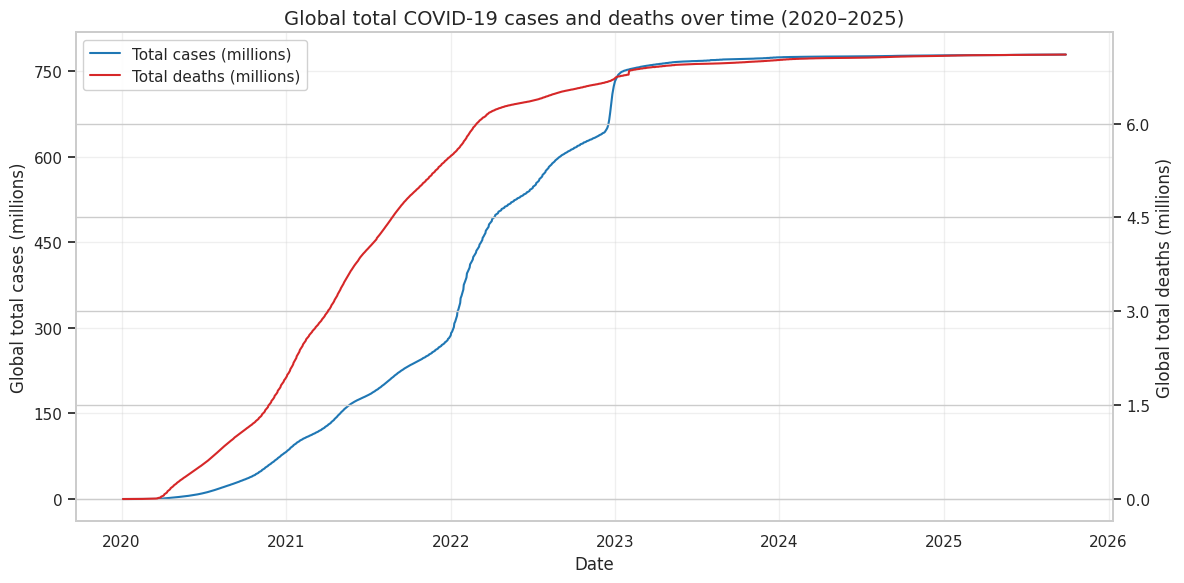

In [83]:
# @title
# Copy and keep only rows with data
plot_df = global_total.dropna(
    subset=["global_total_cases", "global_total_deaths"],
    how="all"
).copy()

# Convert to millions to make the values ​​easier to understand
plot_df["cases_millions"] = plot_df["global_total_cases"] / 1_000_000
plot_df["deaths_millions"] = plot_df["global_total_deaths"] / 1_000_000

fig, ax1 = plt.subplots(figsize=(12, 6))

# global cases curve (left axis)
ax1.plot(
    plot_df["date"],
    plot_df["cases_millions"],
    color="tab:blue",
    label="Total cases (millions)"
)
ax1.set_xlabel("Date")
ax1.set_ylabel("Global total cases (millions)")
ax1.grid(True, alpha=0.3)

# Global deaths curve (right axis)
ax2 = ax1.twinx()
ax2.plot(
    plot_df["date"],
    plot_df["deaths_millions"],
    color="tab:red",
    label="Total deaths (millions)"
)
ax2.set_ylabel("Global total deaths (millions)")

# X-axis: one tick per year, year format
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax1.get_xticklabels(), rotation=0)

# Limit the number of ticks on the Y axes
ax1.yaxis.set_major_locator(MaxNLocator(6))
ax2.yaxis.set_major_locator(MaxNLocator(6))

# Combined legend, with a legible white background
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc="upper left",
    frameon=True,
    framealpha=0.9
)

plt.title("Global total COVID-19 cases and deaths over time (2020–2025)")
plt.tight_layout()
plt.show()


The cumulative curves show a rapid global spread until early 2023, when both cases and deaths reach their peaks. Growth slows sharply afterwards, with totals stabilizing around 760M cases and 6.9M deaths. The plateau from 2023 onward reflects the transition from active pandemic waves to controlled circulation.

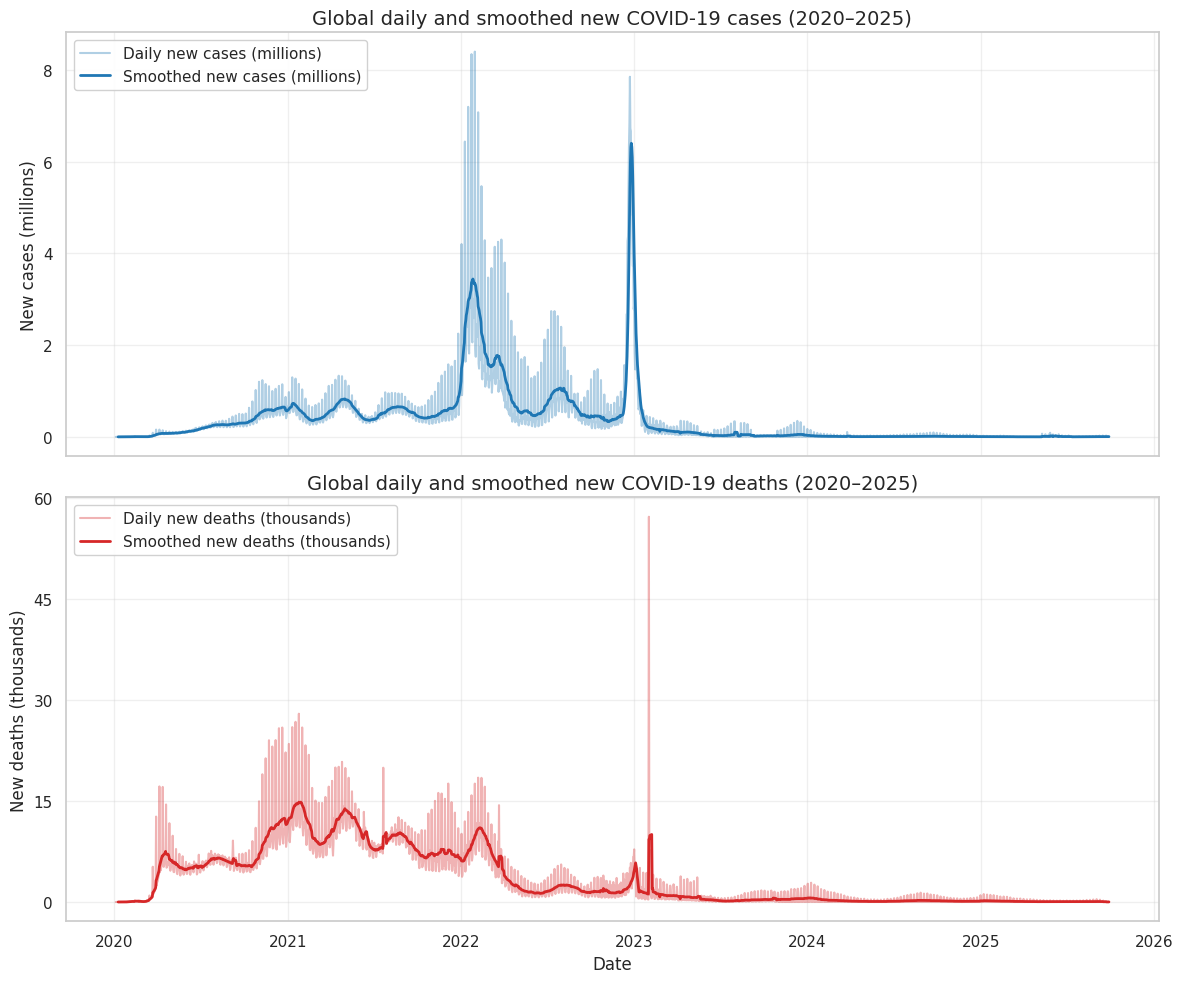

In [84]:
# @title
# Prepare cases dataframe
cases_df = global_daily.dropna(
    subset=["global_new_cases", "global_new_cases_smoothed"],
    how="all"
).copy()
cases_df["new_cases_millions"] = cases_df["global_new_cases"] / 1_000_000
cases_df["new_cases_smoothed_millions"] = cases_df["global_new_cases_smoothed"] / 1_000_000

# Prepare deaths dataframe
deaths_df = global_daily.dropna(
    subset=["global_new_deaths", "global_new_deaths_smoothed"],
    how="all"
).copy()
deaths_df["new_deaths_thousands"] = deaths_df["global_new_deaths"] / 1_000
deaths_df["new_deaths_smoothed_thousands"] = deaths_df["global_new_deaths_smoothed"] / 1_000

# Create figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Subplot 1: New cases ---
axes[0].plot(
    cases_df["date"],
    cases_df["new_cases_millions"],
    color="tab:blue",
    alpha=0.35,
    label="Daily new cases (millions)"
)
axes[0].plot(
    cases_df["date"],
    cases_df["new_cases_smoothed_millions"],
    color="tab:blue",
    linewidth=2.0,
    label="Smoothed new cases (millions)"
)

axes[0].set_title("Global daily and smoothed new COVID-19 cases (2020–2025)")
axes[0].set_ylabel("New cases (millions)")
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc="upper left", frameon=True, framealpha=0.9)
axes[0].yaxis.set_major_locator(MaxNLocator(6))

# --- Subplot 2: New deaths ---
axes[1].plot(
    deaths_df["date"],
    deaths_df["new_deaths_thousands"],
    color="tab:red",
    alpha=0.35,
    label="Daily new deaths (thousands)"
)
axes[1].plot(
    deaths_df["date"],
    deaths_df["new_deaths_smoothed_thousands"],
    color="tab:red",
    linewidth=2.0,
    label="Smoothed new deaths (thousands)"
)

axes[1].set_title("Global daily and smoothed new COVID-19 deaths (2020–2025)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("New deaths (thousands)")
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc="upper left", frameon=True, framealpha=0.9)
axes[1].yaxis.set_major_locator(MaxNLocator(6))

# Shared X-axis formatting
axes[1].xaxis.set_major_locator(mdates.YearLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.show()


The curves show how the pandemic unfolded globally across both transmission and severity. **Daily new cases** display several major waves, with extreme peaks in **early 2022** and a final spike around **early 2023**, while **deaths follow the same pattern with a slight delay**, reflecting the typical lag between infection and mortality. After these peaks, both indicators fall sharply, and by **2024–2025**, new cases and deaths remain close to zero, highlighting the **end of large-scale global transmission** and the stabilization of the pandemic.


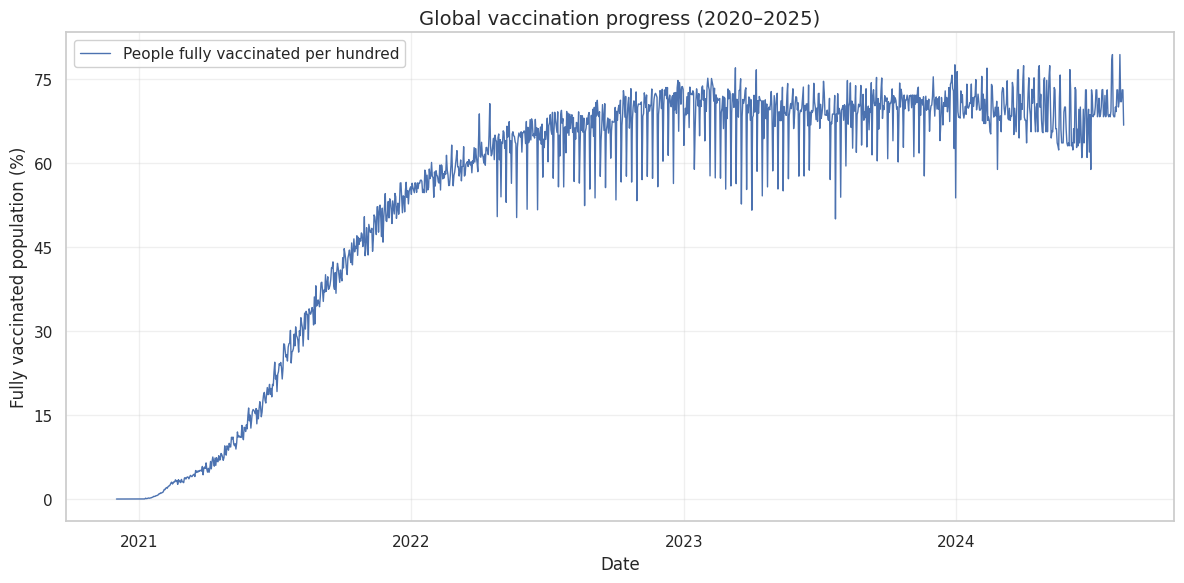

In [85]:
# @title
# Filter and clean vaccination dataframe
vax_df = global_vax.dropna(
    subset=["global_people_fully_vaccinated_per_hundred"],
    how="all"
).copy()

fig, ax = plt.subplots(figsize=(12, 6))

# Line: fully vaccinated per hundred
ax.plot(
    vax_df["date"],
    vax_df["global_people_fully_vaccinated_per_hundred"],
    linewidth=1.0,
    label="People fully vaccinated per hundred"
)

# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("Fully vaccinated population (%)")
ax.set_title("Global vaccination progress (2020–2025)")

# X-axis: yearly ticks
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Limit number of Y ticks
ax.yaxis.set_major_locator(MaxNLocator(6))

ax.grid(True, alpha=0.3)
ax.legend(loc="upper left", frameon=True, framealpha=0.9)

plt.tight_layout()
plt.show()

Vaccination rises sharply during 2021–2022, reaching 60%+ of the global population fully vaccinated. The curve plateaus around 70–75% from 2023 onward, signaling saturation of vaccination campaigns and stabilizing immunity levels worldwide.

In [86]:
# @title
# Continental Comparison URLs
url_cases_continent = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Continental%20Comparison/total_cases_per_million_by_continent.csv"
url_deaths_continent = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Continental%20Comparison/total_deaths_per_million_by_continent.csv"
url_vax_continent = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Continental%20Comparison/vaccination_per_hundred_by_continent.csv"
url_stringency_continent = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Continental%20Comparison/average_stringency_index_by_continent_and_year.csv"

# Load CSVs into dataframes
cases_continent = pd.read_csv(url_cases_continent)
deaths_continent = pd.read_csv(url_deaths_continent)
vax_continent = pd.read_csv(url_vax_continent)
stringency_continent = pd.read_csv(url_stringency_continent)

# Quick sanity check (optional)
display(deaths_continent.head())


,continent,total_deaths_per_million
0,South America,3149.532233
1,North America,2824.299386
2,Europe,2819.344920
3,Oceania,736.298238
4,Asia,347.397996


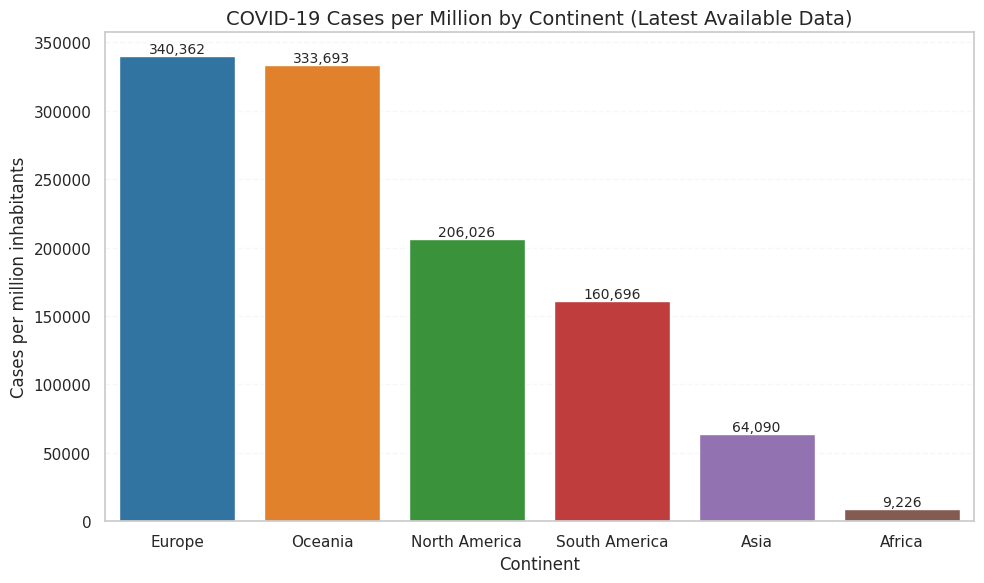

In [87]:
# @title
# Sort by highest burden
cases_continent = cases_continent.sort_values(by="total_cases_per_million", ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=cases_continent,
    x="continent",
    y="total_cases_per_million",
    hue="continent",  # Added hue argument
    palette='tab10',
    legend=False    # Added legend=False
)

# Labels on bars
for p in ax.patches:
    value = int(p.get_height())
    ax.annotate(
        f"{value:,}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.title("COVID-19 Cases per Million by Continent (Latest Available Data)")
plt.xlabel("Continent")
plt.ylabel("Cases per million inhabitants")

plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.15, linestyle="--")

plt.tight_layout()
plt.show()

- **Europe** and **Oceania** show the highest infection levels, both exceeding **330,000 cases per million**, reflecting widespread transmission.
- **North America** and **South America** follow with intermediate levels between **160,000 and 206,000 cases per million**.
- **Asia** reports significantly lower rates (**around 64,000 cases per million**), indicating more contained spread.
- **Africa** shows the lowest level (**about 9,000 cases per million**), which may reflect lower transmission or reduced testing and reporting capacity.


/tmp/ipython-input-2443161999.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


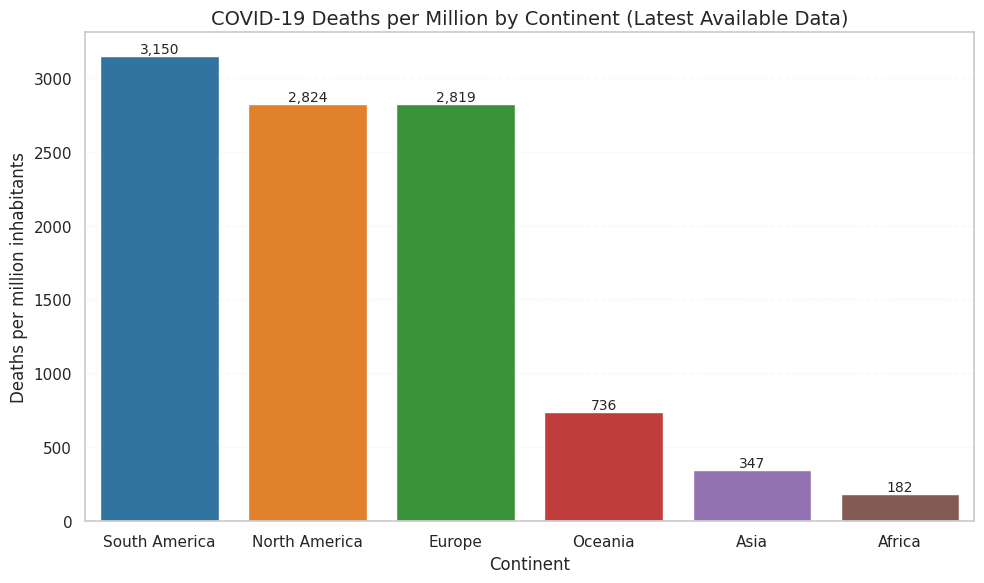

In [88]:
# @title
# Sort by highest mortality burden
deaths_continent_sorted = deaths_continent.sort_values(
    by="total_deaths_per_million",
    ascending=False
).copy()

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=deaths_continent_sorted,
    x="continent",
    y="total_deaths_per_million",
    palette="tab10"
)

# Add value labels on bars
for p in ax.patches:
    value = p.get_height()
    ax.annotate(
        f"{value:,.0f}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.title("COVID-19 Deaths per Million by Continent (Latest Available Data)")
plt.xlabel("Continent")
plt.ylabel("Deaths per million inhabitants")

plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.15, linestyle="--")

plt.tight_layout()
plt.show()


/tmp/ipython-input-2566899782.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


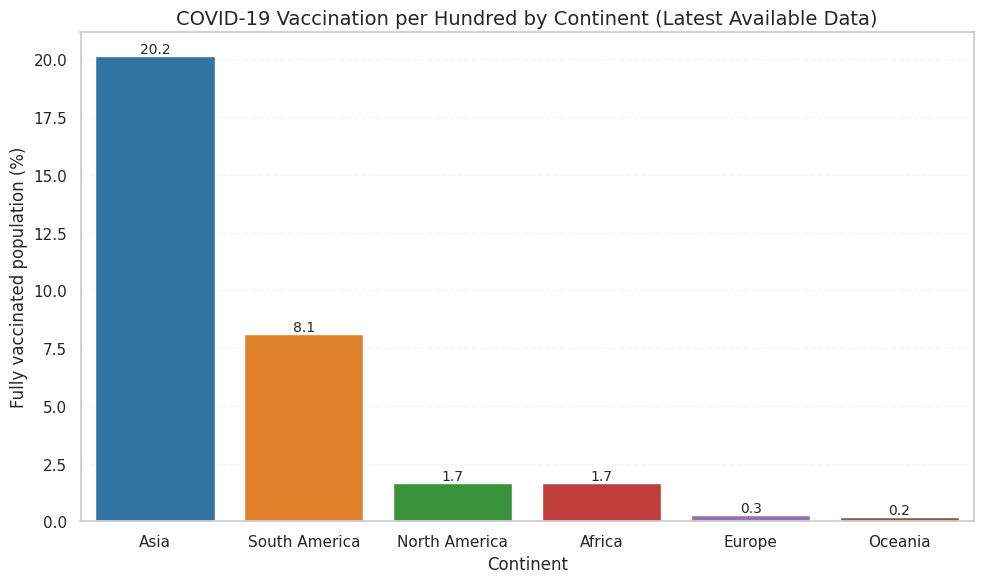

In [89]:
# @title
# Vaccination per hundred by continent

vax_continent_sorted = vax_continent.sort_values(
    by="people_fully_vaccinated_per_hundred",
    ascending=False
).copy()

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=vax_continent_sorted,
    x="continent",
    y="people_fully_vaccinated_per_hundred",
    palette="tab10"
)

# Add numeric labels above bars
for p in ax.patches:
    value = p.get_height()
    ax.annotate(
        f"{value:,.1f}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.title("COVID-19 Vaccination per Hundred by Continent (Latest Available Data)")
plt.xlabel("Continent")
plt.ylabel("Fully vaccinated population (%)")

plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.15, linestyle="--")

plt.tight_layout()
plt.show()


In [90]:
# @title
# Vaccination vs Mortality Analysis URLs
url_vacc_mortality = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Continental%20Comparison/correlation_ready_dataset_vaccination_vs_mortality_with%20continent.csv"
url_mortality_before_after = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Vaccination%20vs%20Mortality%20Analysis/mortality_evolution_before%20vs%20after_vaccination_rollout.csv"
url_mortality_top10_drop = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Vaccination%20vs%20Mortality%20Analysis/top_10_countries_with_the_largest_drop_in_new_deaths_after_vaccination.csv"

# Load CSVs into dataframes
vacc_mortality = pd.read_csv(url_vacc_mortality)
mortality_before_after = pd.read_csv(url_mortality_before_after)
mortality_top10_drop = pd.read_csv(url_mortality_top10_drop)

# Quick sanity check
display(vacc_mortality.head())


,country,continent,people_fully_vaccinated_per_hundred,total_deaths_per_million
0,Benin,Africa,19.934122,11.846355
1,Algeria,Africa,14.251447,151.239990
2,Angola,Africa,26.965265,54.356630
3,Burkina Faso,Africa,23.245539,17.592934
4,Botswana,Africa,68.178760,1147.590300


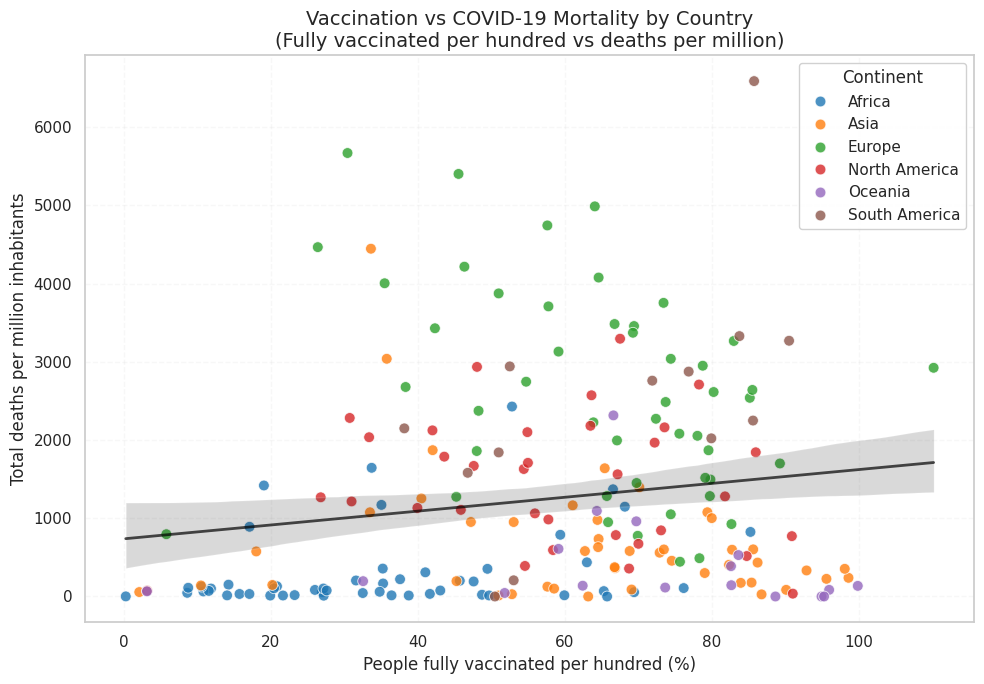

In [91]:
# @title
# Scatter plot: vaccination vs mortality, colored by continent

scatter_df = vacc_mortality.dropna(
    subset=["people_fully_vaccinated_per_hundred", "total_deaths_per_million"],
    how="any"
).copy()

plt.figure(figsize=(10, 7))
ax = sns.scatterplot(
    data=scatter_df,
    x="people_fully_vaccinated_per_hundred",
    y="total_deaths_per_million",
    hue="continent",
    palette="tab10",
    alpha=0.8,
    s=60
)

# Global regression line (no hue)
sns.regplot(
    data=scatter_df,
    x="people_fully_vaccinated_per_hundred",
    y="total_deaths_per_million",
    scatter=False,
    color="black",
    line_kws={"linewidth": 2, "alpha": 0.7},
    ax=ax
)

plt.title("Vaccination vs COVID-19 Mortality by Country\n(Fully vaccinated per hundred vs deaths per million)")
plt.xlabel("People fully vaccinated per hundred (%)")
plt.ylabel("Total deaths per million inhabitants")

plt.grid(alpha=0.15, linestyle="--")
plt.legend(title="Continent", frameon=True, framealpha=0.9)

plt.tight_layout()
plt.show()


The scatter reveals a **highly heterogeneous landscape**: countries with similar vaccination levels show **wide differences** in total deaths per million. The regression line remains almost flat, highlighting that vaccination **alone** does not explain cumulative mortality. Outcomes are strongly shaped by **confounding factors** — early pandemic waves, demographic structure, health-system capacity, reporting practices, and timing of exposure.  
In short, the visual demonstrates that the vaccination ↔ mortality relationship is **complex and deeply influenced by each country’s pandemic history and structural characteristics**, making simple conclusions impossible.

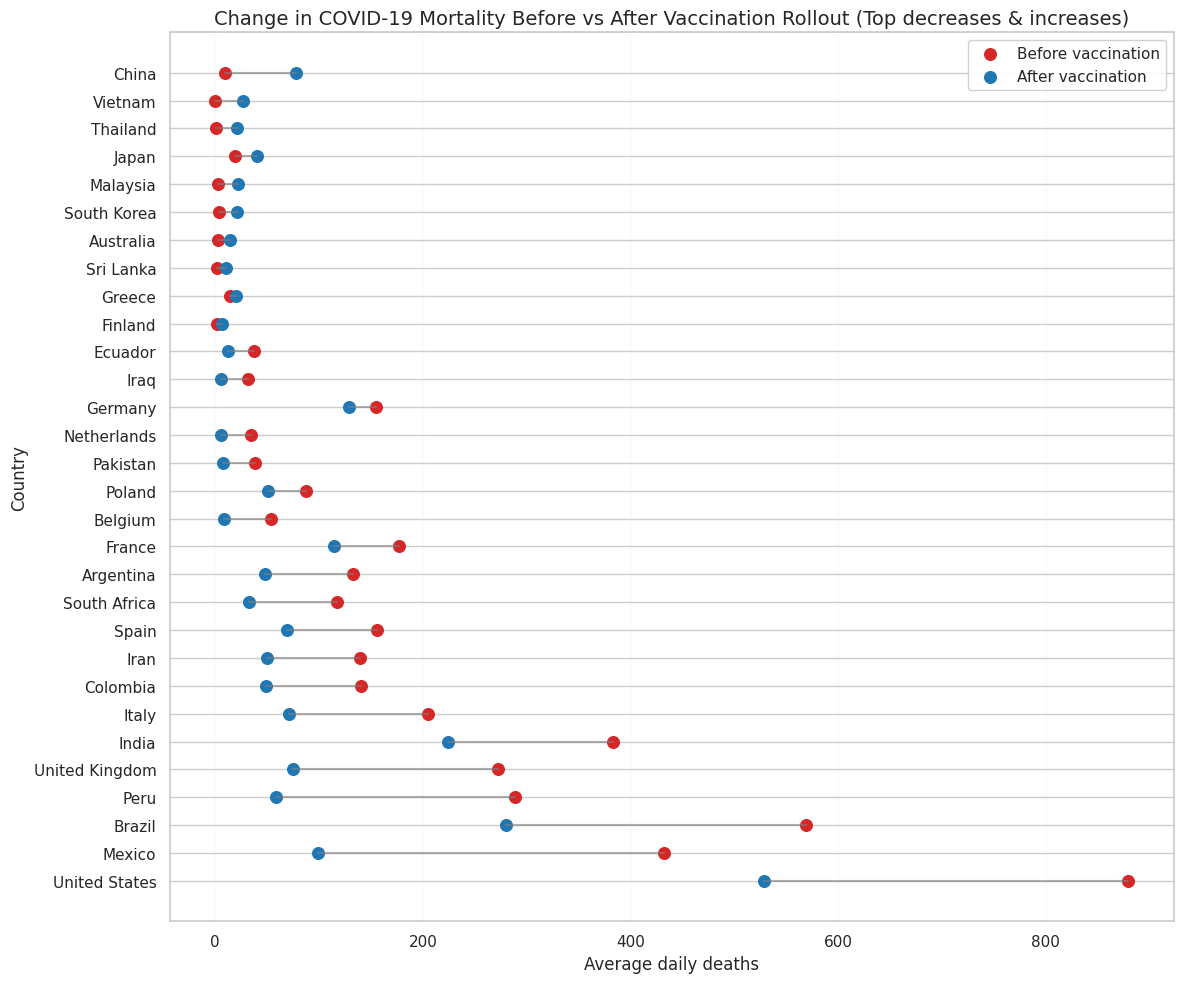

In [92]:
# @title
# Prepare dataframe
df = df_before_after.copy()

# Compute reduction
df["reduction"] = df["avg_new_deaths_before"] - df["avg_new_deaths_after"]

# Select top 20 decreases and top 10 increases
top_decrease = df.nlargest(20, "reduction")
top_increase = df.nsmallest(10, "reduction")

df_subset = pd.concat([top_decrease, top_increase], axis=0)
df_subset = df_subset.sort_values(by="reduction", ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 10))

y_positions = range(len(df_subset))

# BEFORE
plt.scatter(
    df_subset["avg_new_deaths_before"],
    y_positions,
    color="tab:red",
    label="Before vaccination",
    s=70
)

# AFTER
plt.scatter(
    df_subset["avg_new_deaths_after"],
    y_positions,
    color="tab:blue",
    label="After vaccination",
    s=70
)

# Lines connecting the two
for i, row in df_subset.iterrows():
    plt.plot(
        [row["avg_new_deaths_before"], row["avg_new_deaths_after"]],
        [i, i],
        color="gray",
        alpha=0.6,
        linewidth=1.5
    )

plt.yticks(y_positions, df_subset["country"])
plt.xlabel("Average daily deaths")
plt.ylabel("Country")
plt.title("Change in COVID-19 Mortality Before vs After Vaccination Rollout (Top decreases & increases)")

plt.grid(axis="x", alpha=0.15, linestyle="--")
plt.legend(frameon=True, framealpha=0.9, loc="upper right")

plt.tight_layout()
plt.show()


Most countries show a **marked decline** in average daily deaths after vaccination rollout, with some (e.g., **China, Vietnam, Thailand**) dropping nearly to zero. A smaller group displays **increases** (e.g., **United States, Brazil, Mexico**), reflecting major mortality waves occurring **after** vaccines became available or insufficient vaccination coverage during later surges.  
This contrast illustrates how **timing, variant waves, and public-health responses** strongly influence the observed effect of vaccination on mortality.


In [93]:
# @title
# Socio-Economic Drivers of COVID Exposure – URLs
url_gdp_cases = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Socio-Economic%20Drivers%20of%20COVID%20Exposure/gpd_per_capita_vs_total_cases_per_million.csv"
url_lifeexp_deaths = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Socio-Economic%20Drivers%20of%20COVID%20Exposure/life_expectancy_vs_total_deaths_per_million.csv"
url_medianage_deaths = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Socio-Economic%20Drivers%20of%20COVID%20Exposure/median_age_vs%20total_deaths_per_million.csv"
url_popdensity_cases = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Socio-Economic%20Drivers%20of%20COVID%20Exposure/population_density_vs_total_cases_per_million.csv"

# Load CSVs into DataFrames
gdp_cases = pd.read_csv(url_gdp_cases)
lifeexp_deaths = pd.read_csv(url_lifeexp_deaths)
medianage_deaths = pd.read_csv(url_medianage_deaths)
popdensity_cases = pd.read_csv(url_popdensity_cases)

# Quick sanity check
display(gdp_cases.head())
display(lifeexp_deaths.head())


,country,gdp_per_capita,total_cases_per_million
0,Afghanistan,1516.273315,5796.4683
1,Albania,15492.067383,119257.7900
2,Algeria,11198.233398,5990.2515
3,Angola,5906.115723,3016.3298
4,Antigua and Barbuda,22321.869141,98072.1600


,country,life_expectancy,total_deaths_per_million
0,Afghanistan,65.616997,197.09776
1,Albania,78.768799,1275.98740
2,Algeria,76.128899,151.30595
3,American Samoa,72.752098,702.98770
4,Andorra,84.016403,1994.43070


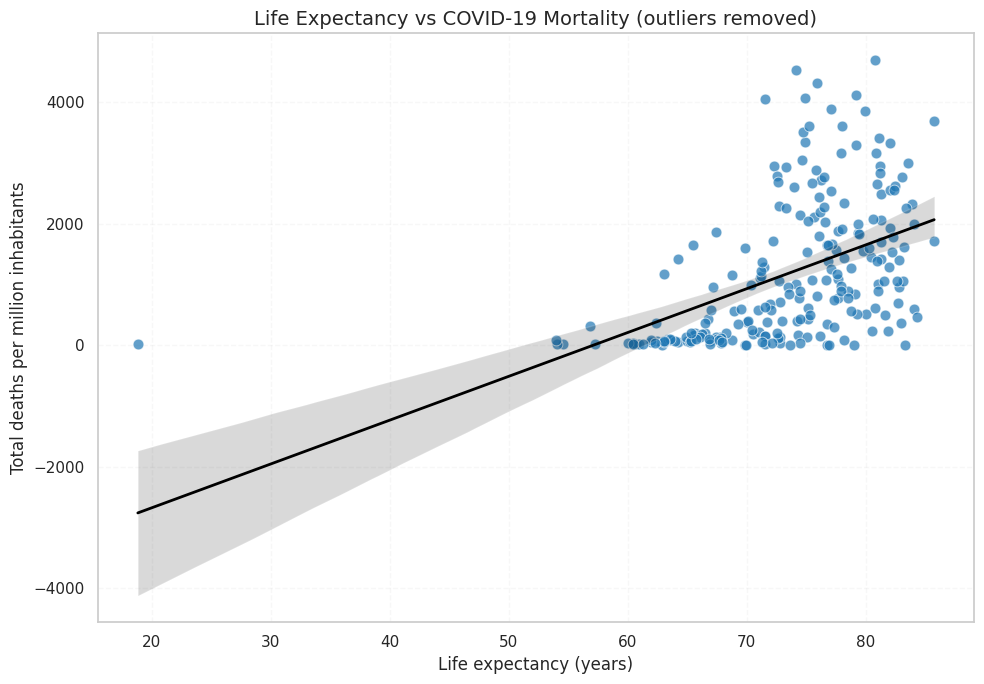

In [95]:
# @title
df = df_lifeexp.copy()

# Remove extreme outliers based on IQR
Q1 = df["total_deaths_per_million"].quantile(0.25)
Q3 = df["total_deaths_per_million"].quantile(0.75)
IQR = Q3 - Q1

df_clean = df[
    (df["total_deaths_per_million"] >= Q1 - 1.5 * IQR) &
    (df["total_deaths_per_million"] <= Q3 + 1.5 * IQR)
].copy()

plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=df_clean,
    x="life_expectancy",
    y="total_deaths_per_million",
    color="tab:blue",
    alpha=0.7,
    s=60
)

sns.regplot(
    data=df_clean,
    x="life_expectancy",
    y="total_deaths_per_million",
    scatter=False,
    color="black",
    line_kws={"linewidth": 2}
)

plt.title("Life Expectancy vs COVID-19 Mortality (outliers removed)")
plt.xlabel("Life expectancy (years)")
plt.ylabel("Total deaths per million inhabitants")
plt.grid(alpha=0.15, linestyle="--")

plt.tight_layout()
plt.show()



Countries with higher life expectancy tend to show **higher COVID-19 mortality per million**, forming an upward trend in the scatterplot. This relationship does not imply a causal effect of longevity itself but reflects the **age structure** of populations: countries where people live longer also have a **larger share of elderly individuals**, who are more vulnerable to severe outcomes. The spread of points around the trend also indicates that **healthcare capacity, testing rates, reporting practices, and the timing of pandemic waves** played a major role in shaping mortality differences across countries.


In [113]:
# @title
# Policy Stringency & Spread Dynamics – URLs
url_stringency_high = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Policy%20Stringency%20and%20Spread%20Dynamics/countries_with_consistently_high_average_stringency_index.csv"
url_stringency_volatility = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Policy%20Stringency%20and%20Spread%20Dynamics/stringency_index_volatility_by_country.csv"
url_stringency_vs_cases = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Policy%20Stringency%20and%20Spread%20Dynamics/stringency_index_vs_new_cases_smoothed.csv"

# Load CSVs into DataFrames
stringency_high = pd.read_csv(url_stringency_high)
stringency_volatility = pd.read_csv(url_stringency_volatility)
stringency_vs_cases = pd.read_csv(url_stringency_vs_cases)

# Quick sanity check
display(stringency_high.head())
display(stringency_volatility.head())


,country,avg_stringency_index
0,China,73.313212
1,Myanmar,63.734462
2,Honduras,62.847701
3,Eritrea,61.988330
4,Azerbaijan,59.991551


,country,avg_stringency_index,volatility_stringency_index
0,Venezuela,55.201442,34.049388
1,Palestine,51.668148,32.987968
2,Argentina,52.429097,31.840522
3,Dominican Republic,45.041661,31.766403
4,Bangladesh,49.973394,31.322264


/tmp/ipython-input-1122340693.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


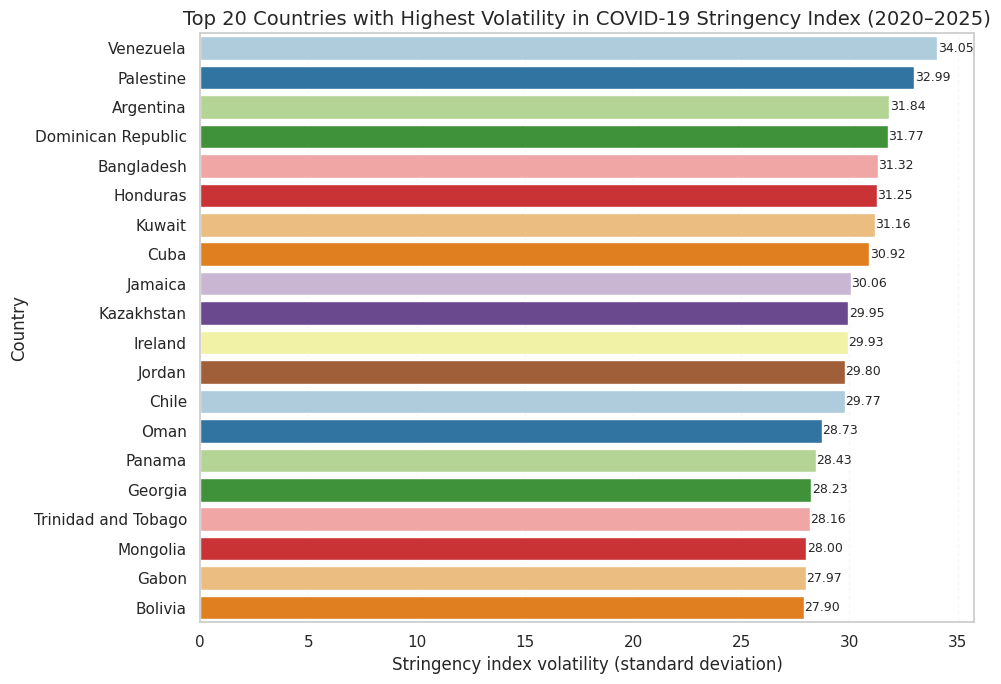

In [114]:
# @title
# Select Top 20 most volatile countries
df_top20 = stringency_volatility.sort_values(
    by="volatility_stringency_index",
    ascending=False
).head(20).copy()

plt.figure(figsize=(10, 7))
ax = sns.barplot(
    data=df_top20,
    x="volatility_stringency_index",
    y="country",
    palette="Paired"
)

# Add value labels
for p in ax.patches:
    value = p.get_width()
    ax.annotate(
        f"{value:,.2f}",
        (p.get_x() + p.get_width() + 0.02, p.get_y() + p.get_height() / 2),
        ha="left",
        va="center",
        fontsize=9
    )

plt.title("Top 20 Countries with Highest Volatility in COVID-19 Stringency Index (2020–2025)")
plt.xlabel("Stringency index volatility (standard deviation)")
plt.ylabel("Country")

plt.grid(axis="x", alpha=0.15, linestyle="--")

plt.tight_layout()
plt.show()


/tmp/ipython-input-2573988479.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


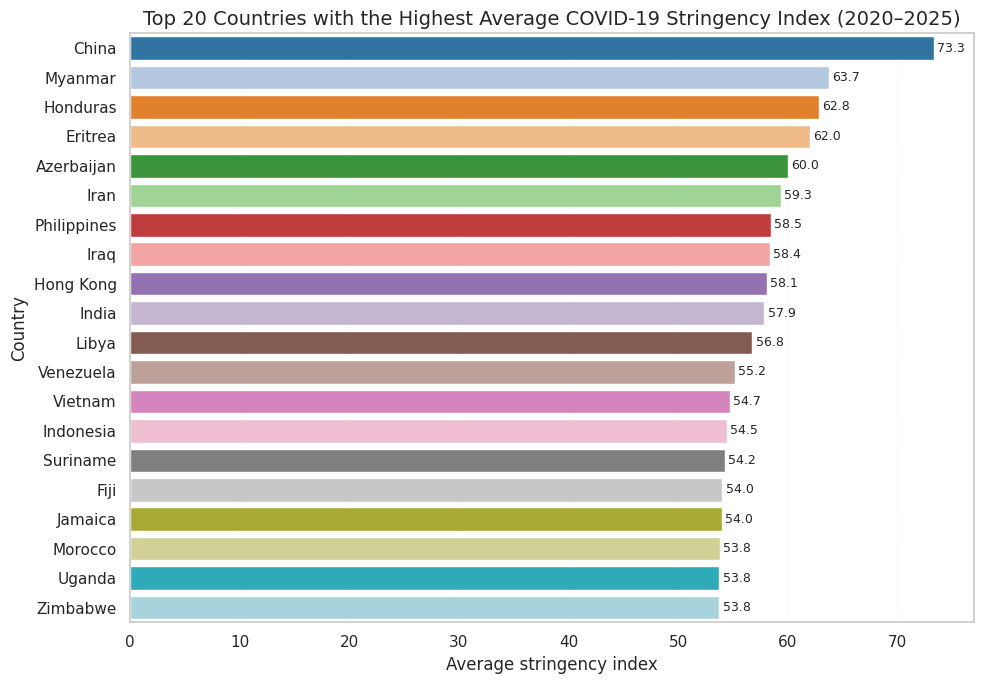

In [105]:
# @title
# Top 20 Countries with the Highest Average COVID-19 Stringency Index
df_top20 = (
    df_high.sort_values(by="avg_stringency_index", ascending=False)
            .head(20)
)

plt.figure(figsize=(10, 7))

ax = sns.barplot(
    data=df_top20,
    x="avg_stringency_index",
    y="country",
    palette="tab20"
)

# Labels numériques
for p in ax.patches:
    value = p.get_width()
    ax.text(
        value + 0.3,
        p.get_y() + p.get_height() / 2,
        f"{value:.1f}",
        va="center",
        fontsize=9
    )

plt.title("Top 20 Countries with the Highest Average COVID-19 Stringency Index (2020–2025)")
plt.xlabel("Average stringency index")
plt.ylabel("Country")

plt.grid(axis="x", alpha=0.15, linestyle="--")
plt.tight_layout()
plt.show()


In [119]:
# @title

# Policy Stringency & Spread Dynamics – URLs
url_stringency_high = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Policy%20Stringency%20and%20Spread%20Dynamics/countries_with_consistently_high_average_stringency_index.csv"
url_stringency_volatility = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Policy%20Stringency%20and%20Spread%20Dynamics/stringency_index_volatility_by_country.csv"
url_stringency_vs_cases = "https://raw.githubusercontent.com/zakabdelhamid/Exploratory-Analysis-of-COVID-19-2020-2025/refs/heads/main/data/Policy%20Stringency%20and%20Spread%20Dynamics/stringency_index_vs_new_cases_smoothed.csv"

# Load CSVs
stringency_high = pd.read_csv(url_stringency_high)
stringency_volatility = pd.read_csv(url_stringency_volatility)
stringency_vs_cases = pd.read_csv(url_stringency_vs_cases)

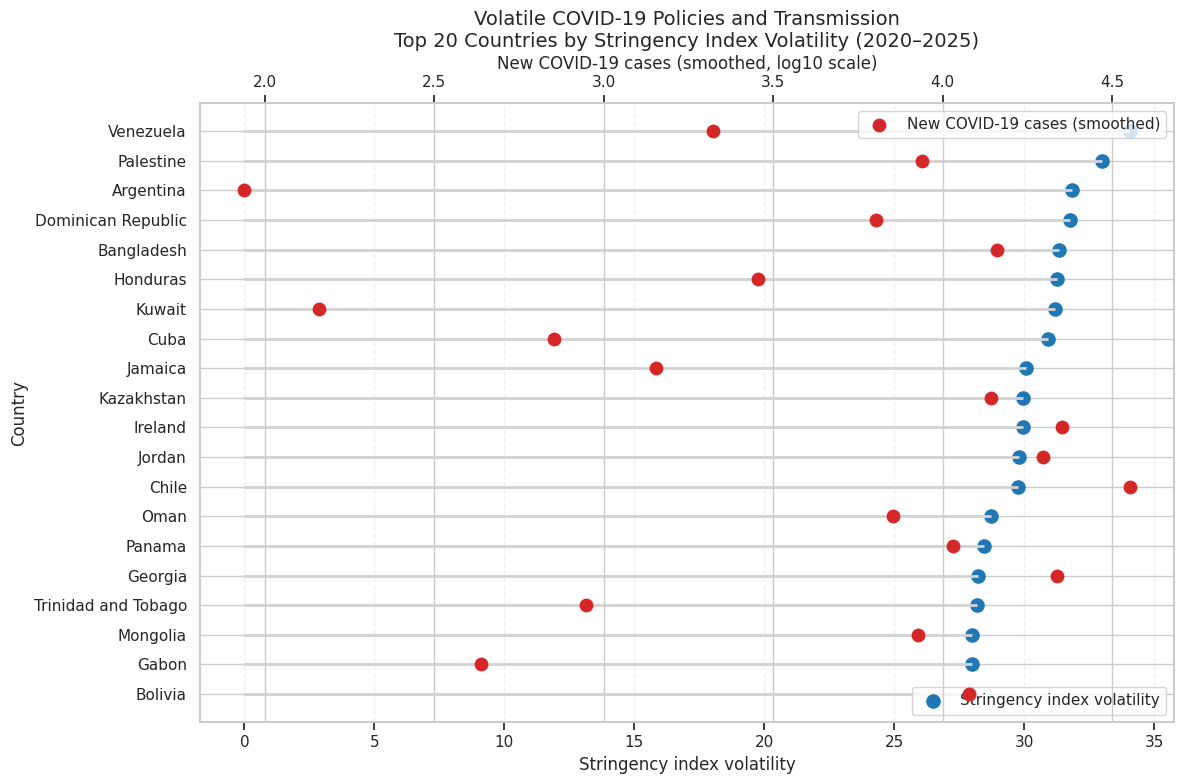

In [125]:
# @title
# Top 20 countries with highest volatility in stringency index
top20_volatile = (
    stringency_volatility
    .sort_values(by="volatility_stringency_index", ascending=False)
    .head(20)
    .copy()
)

# Merge volatility with transmission dataset
df_vol_cases = top20_volatile.merge(
    stringency_vs_cases[["country", "new_cases_smoothed"]],
    on="country",
    how="left"
)

# Sort ascending for cleaner lollipop layout
df_vol_cases = df_vol_cases.sort_values(
    by="volatility_stringency_index",
    ascending=True
)

plt.figure(figsize=(12, 8))
ax = plt.gca()

# --- Lollipop chart: stringency volatility ---
ax.hlines(
    df_vol_cases["country"],
    xmin=0,
    xmax=df_vol_cases["volatility_stringency_index"],
    color="lightgray",
    linewidth=2
)

ax.scatter(
    df_vol_cases["volatility_stringency_index"],
    df_vol_cases["country"],
    color="tab:blue",
    s=90,
    label="Stringency index volatility"
)

ax.set_xlabel("Stringency index volatility")
ax.set_ylabel("Country")

# --- Second axis: transmission (log10) ---
ax2 = ax.twiny()

df_vol_cases["log_cases"] = np.log10(df_vol_cases["new_cases_smoothed"] + 1)

ax2.scatter(
    df_vol_cases["log_cases"],
    df_vol_cases["country"],
    color="tab:red",
    s=80,
    label="New COVID-19 cases (smoothed)"
)

ax2.set_xlabel("New COVID-19 cases (smoothed, log10 scale)")

# Titles
plt.title("Volatile COVID-19 Policies and Transmission\nTop 20 Countries by Stringency Index Volatility (2020–2025)")

# Legends
ax.legend(loc="lower right")
ax2.legend(loc="upper right")

# Grid for volatility axis
ax.grid(axis="x", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


Highly volatile COVID-19 policy environments show **no clear reduction in new cases**, and several countries with strong fluctuations still reach **high transmission levels**. Frequent tightening and loosening of measures may reflect reactive policymaking rather than sustained control. This volatility likely overlaps with other factors—economic constraints, compliance fatigue, and inconsistent testing practices—showing that unstable policy strategies do not reliably suppress transmission and may even signal structural challenges in epidemic management.


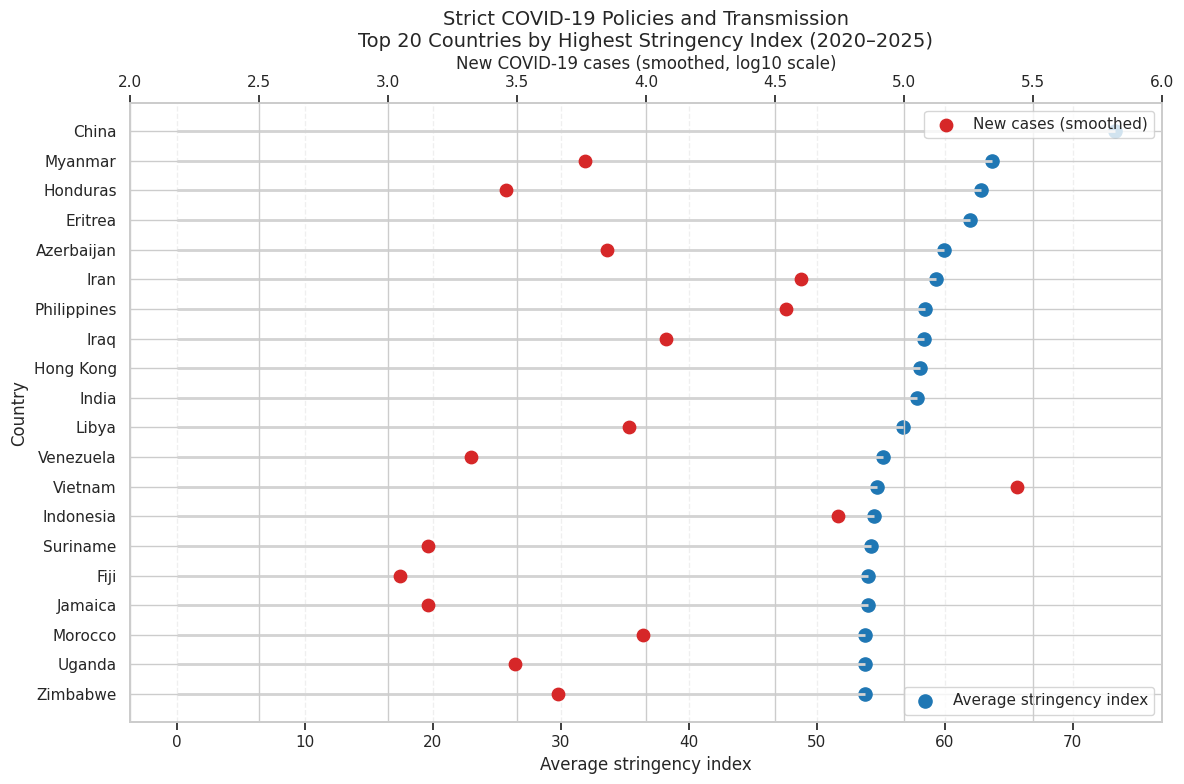

In [126]:
# @title
# Merge top 20 strictest countries with cases dataset
top20 = stringency_high.head(20).copy()
df_merge = top20.merge(stringency_vs_cases, on="country", how="left")

# Sort for cleaner plotting
df_merge = df_merge.sort_values(by="avg_stringency_index", ascending=True)

plt.figure(figsize=(12, 8))
ax = plt.gca()

# --- Lollipop (stringency index) ---
ax.hlines(
    df_merge["country"],
    xmin=0,
    xmax=df_merge["avg_stringency_index"],
    color="lightgray",
    linewidth=2
)
ax.scatter(
    df_merge["avg_stringency_index"],
    df_merge["country"],
    color="tab:blue",
    s=90,
    label="Average stringency index"
)

ax.set_xlabel("Average stringency index")
ax.set_ylabel("Country")

# --- Secondary axis: new cases smoothed ---
ax2 = ax.twiny()

# Log transform for readability
df_merge["log_cases"] = np.log10(df_merge["new_cases_smoothed"] + 1)

ax2.scatter(
    df_merge["log_cases"],
    df_merge["country"],
    color="tab:red",
    s=80,
    label="New cases (smoothed)"
)

# FIXED SCALE: 2.0 → 6.0
ax2.set_xlim(2.0, 6.0)
ax2.set_xticks([2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0])
ax2.set_xticklabels([f"{t:.1f}" for t in ax2.get_xticks()])

ax2.set_xlabel("New COVID-19 cases (smoothed, log10 scale)")

# Titles and legends
plt.title("Strict COVID-19 Policies and Transmission\nTop 20 Countries by Highest Stringency Index (2020–2025)")

ax.legend(loc="lower right")
ax2.legend(loc="upper right")

# Grid on main axis
ax.grid(axis="x", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


Countries with the strictest average COVID-19 policies do not consistently report lower transmission. Some highly strict settings record **higher smoothed case levels**, while others show moderate or low levels. This suggests that strict policies alone do not determine epidemic outcomes. Timing of interventions, testing capacity, population density, and reporting practices all influence observed case levels, making the relationship between policy strictness and transmission more complex than a simple cause-effect link.


## Conclusion

Across all indicators examined, the exploratory analysis highlights a pandemic characterized by strong global synchrony during major waves, followed by a clear stabilization phase from 2023 onward. Transmission and mortality patterns reveal substantial geographic heterogeneity, shaped by demographic structures, health-system capacities, and reporting practices rather than by single factors such as vaccination coverage or policy strictness alone.

Vaccination rollout contributed to a marked reduction in mortality in most countries, but cumulative death levels remain primarily anchored to early-wave exposure and population vulnerability. Similarly, strict or highly variable policy responses do not exhibit a uniform relationship with transmission outcomes, indicating that epidemic trajectories depend on the timing and consistency of interventions as well as broader structural conditions.

Overall, the analysis shows that COVID-19 outcomes emerge from the interaction of multiple determinants—epidemiological, demographic, structural, and political—underscoring the complexity of interpreting global patterns over the 2020–2025 period.
